# Describe data used in model training (HETDEX)

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
import mpl_scatter_density
from sklearn.model_selection import train_test_split
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import colorcet as cc
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [4]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

---

## Reading data

#### Random seed

In [5]:
seed = 42

#### File name

In [6]:
cat_path            = '../../Catalogs/'  # relative path to the same directory

In [7]:
save_plot_flag      = False

In [8]:
used_area           = 'S82'  # can be 'S82', 'HETDEX', 'COSMOS'
if used_area == 'HETDEX':
    used_subset     = 'all'  # 'training', 'test', 'train_test', 'validation', 'unknown', 'all'

In [9]:
file_S82            = 'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_HETDEX         = 'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'
file_COSMOS         = 'CatWISE2020_COSMOS_MILLIQUAS_7_4d_COSMOSVLA3_PS1_GALEX_TGSS_VLASS_XMM_2MASS_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_S82_Ananna_17  = f'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_Ananna_17_zsp_5sigma_imp.h5'  # 204 objects

file_name_dict      = {'S82': file_S82, 'HETDEX': file_HETDEX, 'COSMOS': file_COSMOS}
file_name           = file_name_dict[used_area]

In [10]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Fint_VLAS82', 'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [11]:
full_catalog_df     = pd.read_hdf(cat_path + file_name, key='df').drop(columns=features_2_discard)

In [12]:
full_catalog_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369093 entries, 0 to 369092
Data columns (total 48 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   RA_ICRS       369093 non-null  float32
 1   DE_ICRS       369093 non-null  float32
 2   Name          369093 non-null  object 
 3   TYPE          369093 non-null  object 
 4   Z             2930 non-null    float32
 5   zsp           665 non-null     float32
 6   band_num      369093 non-null  int64  
 7   radio_detect  369093 non-null  bool   
 8   is_AGN        369093 non-null  int64  
 9   is_SDSS_gal   369093 non-null  int64  
 10  is_gal        369093 non-null  int64  
 11  W1mproPM      369093 non-null  float32
 12  W2mproPM      369093 non-null  float32
 13  gmag          369093 non-null  float32
 14  rmag          369093 non-null  float32
 15  imag          369093 non-null  float32
 16  zmag          369093 non-null  float32
 17  ymag          369093 non-null  float32
 18  FUVm

In [13]:
if used_area == 'HETDEX' and used_subset != 'unknown' and used_subset != 'all':
    full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)]
if used_area == 'HETDEX' and used_subset == 'unknown':
    full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] != 0) & (full_catalog_df.loc[:, 'is_AGN'] != 1)]

In [14]:
if used_area == 'HETDEX' and used_subset == 'all':
    full_catalog_df = full_catalog_df
elif used_area == 'HETDEX' and used_subset != 'unknown':
    train_test_df, validation_df     = train_test_split(full_catalog_df, test_size=0.2,\
                                       random_state=seed, stratify=full_catalog_df.loc[:, 'is_AGN'])
    train_df, test_df                = train_test_split(train_test_df, test_size=0.3,\
                                       random_state=seed, stratify=train_test_df.loc[:, 'is_AGN'])
    print('Shape of used data in HETDEX')
    print('(Confirmed galaxies and AGN)')
    print('-' * 50)
    print(f'Full Dataset size:                  {full_catalog_df.shape}')
    print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
    print(f'Training data:                      {train_df.shape}')
    print(f'Testing data:                       {test_df.shape}')
    print(f'Unseen Data For Validation:         {validation_df.shape}')
    print('-' * 50)

In [15]:
if used_area == 'HETDEX':
    print(f'Using {used_subset} data from HETDEX')
    if used_subset != 'unknown' and used_subset != 'all':
        selected_dataset = {'training': train_df, 'test': test_df, 'train_test': train_test_df, 'validation': validation_df}
        full_catalog_df = selected_dataset[used_subset]

In [16]:
full_catalog_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369093 entries, 0 to 369092
Data columns (total 48 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   RA_ICRS       369093 non-null  float32
 1   DE_ICRS       369093 non-null  float32
 2   Name          369093 non-null  object 
 3   TYPE          369093 non-null  object 
 4   Z             2930 non-null    float32
 5   zsp           665 non-null     float32
 6   band_num      369093 non-null  int64  
 7   radio_detect  369093 non-null  bool   
 8   is_AGN        369093 non-null  int64  
 9   is_SDSS_gal   369093 non-null  int64  
 10  is_gal        369093 non-null  int64  
 11  W1mproPM      369093 non-null  float32
 12  W2mproPM      369093 non-null  float32
 13  gmag          369093 non-null  float32
 14  rmag          369093 non-null  float32
 15  imag          369093 non-null  float32
 16  zmag          369093 non-null  float32
 17  ymag          369093 non-null  float32
 18  FUVm

---

## Description plots

In [17]:
bands_plot = ['FUVmag', 'NUVmag', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'Jmag',
              'Hmag', 'Kmag', 'W1mproPM', 'W2mproPM', 'W3mag', 'W4mag']

In [18]:
mag_cols_lim = {'W1mproPM': 20.13, 'W2mproPM': 19.81, 'Sint_LOFAR': 17.52, 'Total_flux_VLASS': 15.21,\
                    'TotalFlux_LoLSS': 12.91, 'Stotal_TGSS': 11.18, 'Fint_VLAS82': 17.86,\
                    'Flux_COSMOSVLA3': 21.25, 'W1mag': 19.6, 'W2mag': 19.34, 'W3mag': 16.67,\
                    'W4mag': 14.62, 'gmag': 23.3, 'rmag': 23.2, 'imag': 23.1, 'zmag': 22.3,\
                    'ymag': 21.4, 'FUVmag': 20.0, 'NUVmag': 21.0, 'FEP': 57.9, 'Jmag': 17.45,\
                    'Hmag': 17.24, 'Kmag': 16.59}  # Proper (5-sigma) limits

for key in mag_cols_lim:
    mag_cols_lim[key] = np.float32(mag_cols_lim[key])

In [19]:
mag_cols_names   = {'W1mproPM': 'W1 (CW)', 'W2mproPM': 'W2 (CW)', 'Sint_LOFAR': 'LOFAR', 'Total_flux_VLASS': 'VLASS', 
                  'TotalFlux_LoLSS': 'LoLSS', 'Stotal_TGSS': 'TGSS', 'W1mag': 'W1 (AW)', 
                  'W2mag': 'W2 (AW)', 'W3mag': 'W3 (AW)', 'W4mag': 'W4 (AW)', 'gmag': 'g', 'rmag': 'r', 
                  'imag': 'i', 'zmag': 'z', 'ymag': 'y', 'FUVmag': 'FUV', 'NUVmag': 'NUV', 
                  'FEP': 'XMM', 'Jmag': 'J', 'Hmag': 'H', 'Kmag': 'K'}

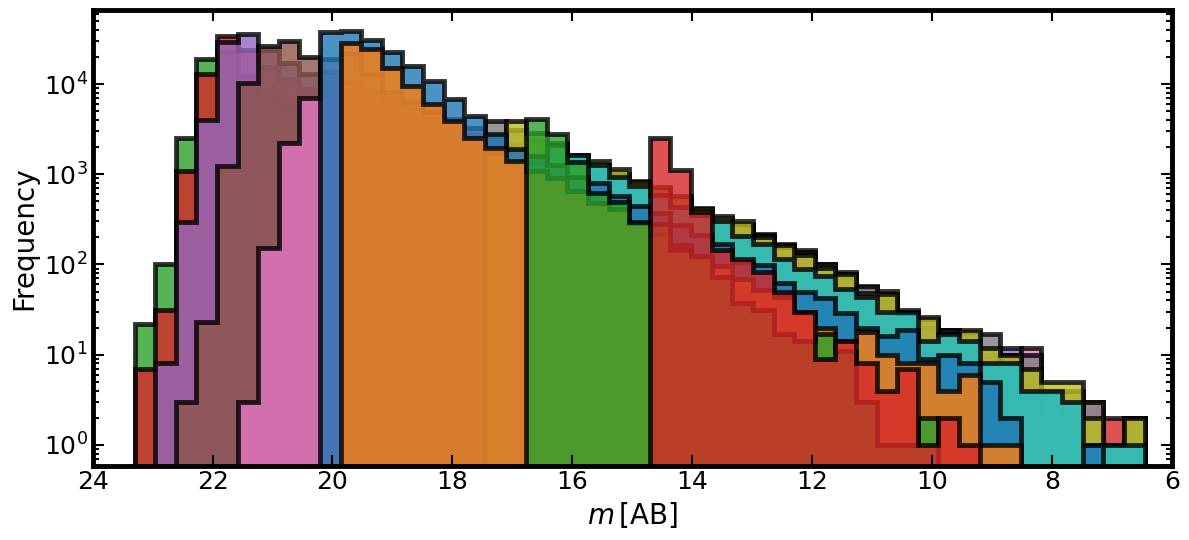

In [20]:
fig             = plt.figure(figsize=(12,5.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_magnitude  = full_catalog_df.loc[:, bands_plot].min().min()
max_magnitude  = full_catalog_df.loc[:, bands_plot].max().max()
mag_bins       = np.linspace(min_magnitude, max_magnitude, 50)

for band in bands_plot:
    filt_lims = np.array(full_catalog_df.loc[:, band] != mag_cols_lim[band])
    ax1.hist(full_catalog_df.loc[filt_lims, band], bins=mag_bins, histtype='stepfilled', ec='k', lw=3.5, alpha=0.8)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$m\, \mathrm{[AB]}$', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
# plt.legend(loc=1, fontsize=14)
ax1.set_xlim(left=np.floor(min_magnitude), right=np.ceil(max_magnitude))
ax1.invert_xaxis()
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

/tmp/ipykernel_11863/395028216.py:53: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


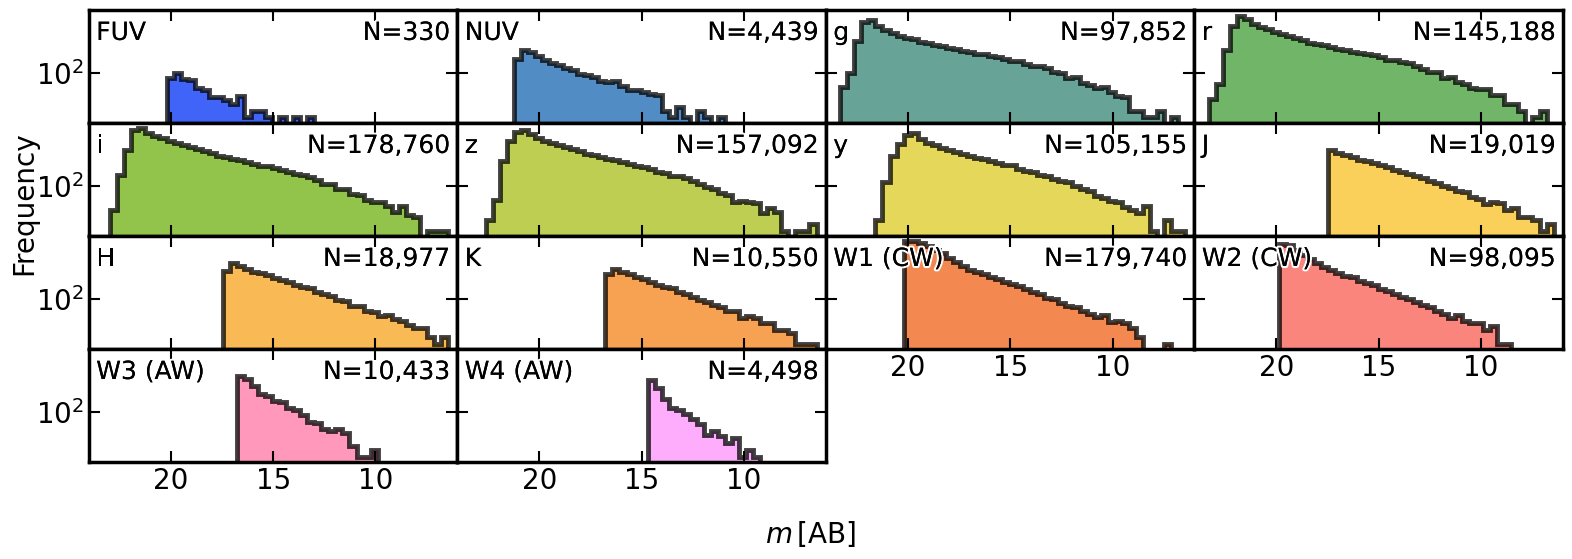

In [21]:
n_cols = 4
n_rows = int(np.ceil((len(bands_plot)) / 4))

min_magnitude  = full_catalog_df.loc[:, bands_plot].min().min()
max_magnitude  = full_catalog_df.loc[:, bands_plot].max().max()
mag_bins       = np.linspace(min_magnitude, max_magnitude, 50)

fig             = plt.figure(figsize=(4 * n_cols, 1.4 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
norm_z = mcolors.Normalize(vmin=0, vmax=8)

for count, band in enumerate(bands_plot):
    if count == 0:
        axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                     xscale='linear', yscale='log')
    elif count != 0:
        axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                     sharex=axs[0], sharey=axs[0])
    
    filt_lims = np.array(full_catalog_df.loc[:, band] != mag_cols_lim[band])
    axs[count].hist(full_catalog_df.loc[filt_lims, band], bins=mag_bins, histtype='stepfilled',
                    ec='k', lw=3.5, fc=plt.get_cmap('cet_CET_R1', len(bands_plot))(count),
                    alpha=0.75, label=f'{band}')
    
    axs[count].tick_params(which='both', top=True, right=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=20)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    #axs[count].grid(zorder=0)
    if count % n_cols != 0:
        plt.setp(axs[count].get_yticklabels(), visible=False)
    # if np.ceil((count + 1) / n_cols) != n_rows:
    #     plt.setp(axs[count].get_xticklabels(), visible=False)
    if count < (len(bands_plot) - n_cols):
        plt.setp(axs[count].get_xticklabels(), visible=False)
    axs[count].annotate(text=f'{mag_cols_names[band]}', xy=(0.02, 0.9),\
                         xycoords='axes fraction', fontsize=18, ha='left', va='top', path_effects=pe2)
    axs[count].annotate(text=f'N={np.sum(filt_lims):,}', xy=(0.98, 0.9),\
                         xycoords='axes fraction', fontsize=18, ha='right', va='top', path_effects=pe2)
    axs[0].set_xlim(left=np.floor(min_magnitude), right=np.ceil(max_magnitude))
    axs[0].invert_xaxis()
    # axs[count].legend(loc=2)


fig.supxlabel('$m\, \mathrm{[AB]}$', fontsize=20, x=0.52)
fig.supylabel('Frequency', fontsize=20, va='bottom')

fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hists_bands_{used_area}.pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_11863/2649010017.py:62: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


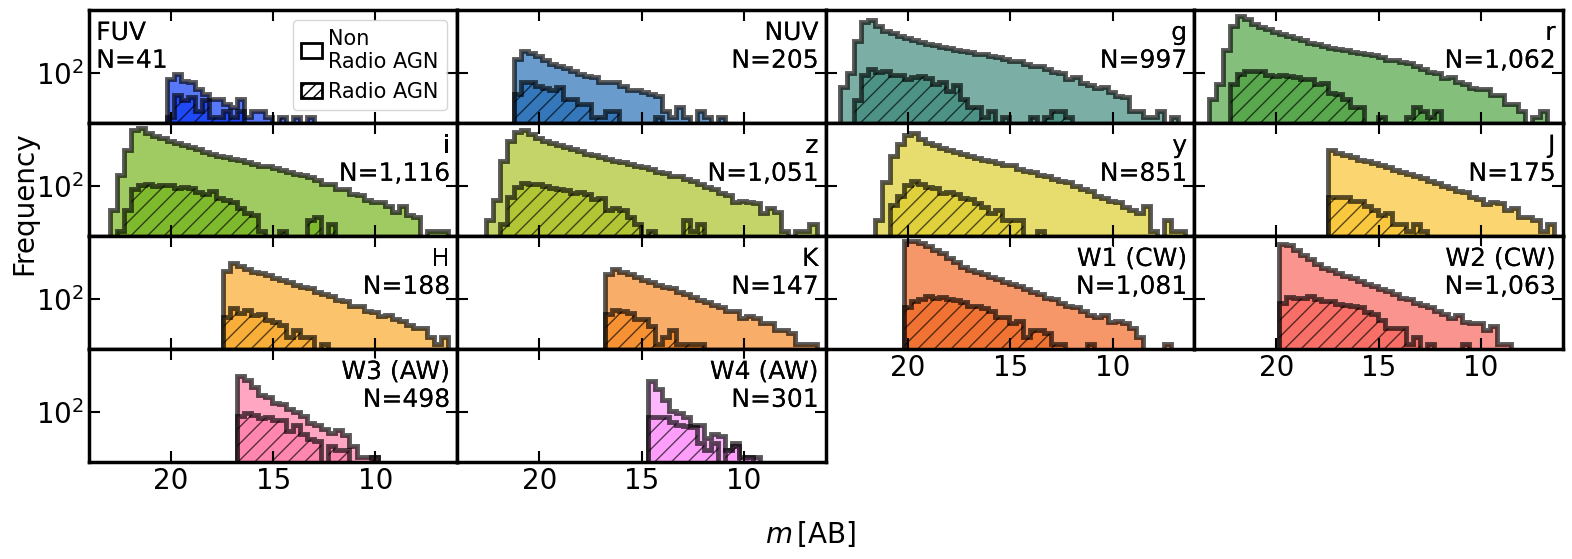

In [22]:
n_cols = 4
n_rows = int(np.ceil((len(bands_plot)) / 4))

min_magnitude  = full_catalog_df.loc[:, bands_plot].min().min()
max_magnitude  = full_catalog_df.loc[:, bands_plot].max().max()
mag_bins       = np.linspace(min_magnitude, max_magnitude, 50)

fig             = plt.figure(figsize=(4 * n_cols, 1.4 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
norm_z = mcolors.Normalize(vmin=0, vmax=8)

for count, band in enumerate(bands_plot):
    if count == 0:
        axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                     xscale='linear', yscale='log')
    elif count != 0:
        axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                     sharex=axs[0], sharey=axs[0])
    # used_cols  = unique_cols_imp.index[count:]
    # print(used_cols)
    # print(new_band)
    
    filt_lims      = np.array(full_catalog_df.loc[:, band] != mag_cols_lim[band])
    filt_radio_agn = np.array(full_catalog_df.loc[:, 'radio_detect'] == 1) & np.array(full_catalog_df.loc[:, 'is_AGN'] == 1)
    axs[count].hist(full_catalog_df.loc[filt_lims & ~filt_radio_agn, band], bins=mag_bins, histtype='stepfilled',
                    ec='k', lw=3.5, fc=plt.get_cmap('cet_CET_R1', len(bands_plot))(count),
                    alpha=0.65, label=f'{band}')
    axs[count].hist(full_catalog_df.loc[filt_lims & filt_radio_agn, band], bins=mag_bins, histtype='stepfilled',
                    ec='k', lw=3.5, fc=plt.get_cmap('cet_CET_R1', len(bands_plot))(count),
                    alpha=0.65, label=f'{band}', hatch='//')
    axs[count].tick_params(which='both', top=True, right=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=20)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    #axs[count].grid(zorder=0)
    if count % n_cols != 0:
        plt.setp(axs[count].get_yticklabels(), visible=False)
    if count < (len(bands_plot) - n_cols):
        plt.setp(axs[count].get_xticklabels(), visible=False)
    if count == 0:
        axs[count].annotate(text=f'{mag_cols_names[band]}\nN={np.sum(filt_lims & filt_radio_agn):,}', xy=(0.02, 0.9),\
                             xycoords='axes fraction', fontsize=18, ha='left', va='top', path_effects=pe2)
    if count != 0:
        axs[count].annotate(text=f'{mag_cols_names[band]}\nN={np.sum(filt_lims & filt_radio_agn):,}', xy=(0.98, 0.9),\
                             xycoords='axes fraction', fontsize=18, ha='right', va='top', path_effects=pe2)
axs[0].set_xlim(left=np.floor(min_magnitude), right=np.ceil(max_magnitude))
axs[0].invert_xaxis()

radio_AGN_patch     = mpatches.Patch(fc='None', ec='k', label='Non\nRadio AGN', lw=2.0)
non_radio_AGN_patch = mpatches.Patch(fc='None', ec='k', label='Radio AGN', hatch='///', lw=2.0)
axs[0].legend(handles=[radio_AGN_patch, non_radio_AGN_patch], loc=1, fontsize=15,
              handletextpad=0.3, handlelength=1.0)

fig.supxlabel('$m\, \mathrm{[AB]}$', fontsize=20, x=0.52)
fig.supylabel('Frequency', fontsize=20, va='bottom')

fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hists_bands_radio_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

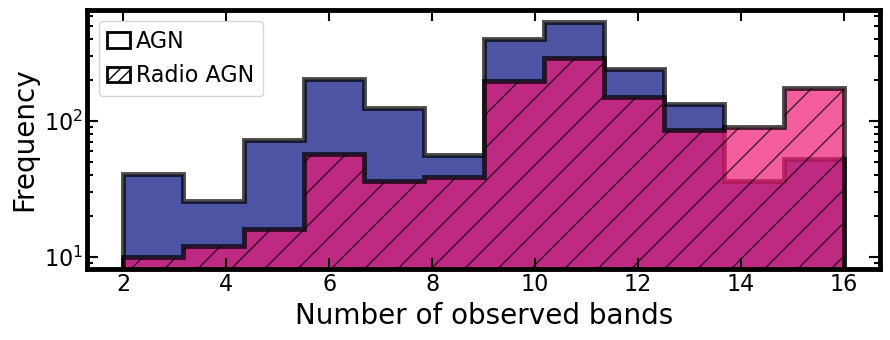

In [23]:
fig             = plt.figure(figsize=(9,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

filt_AGN        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1)
filt_nrad_AGN   = np.array(full_catalog_df.loc[:, 'radio_detect'] == 0) & np.array(full_catalog_df.loc[:, 'is_AGN'] == 1)
filt_radio_AGN  = np.array(full_catalog_df.loc[:, 'radio_detect'] == 1) & np.array(full_catalog_df.loc[:, 'is_AGN'] == 1)

min_num_band   = full_catalog_df.loc[:, 'band_num'].min()
max_num_band   = full_catalog_df.loc[:, 'band_num'].max()
band_bins      = np.linspace(min_num_band, max_num_band, 13)

_, bins, _ = ax1.hist(full_catalog_df.loc[filt_nrad_AGN, 'band_num'], bins=band_bins, histtype='stepfilled', ec='k',
                      fc=plt.get_cmap('cet_bmy',3)(0.0), lw=3.5, label='Non radio AGN', alpha=0.7, density=False)
ax1.hist(full_catalog_df.loc[filt_radio_AGN, 'band_num'], bins=band_bins, histtype='stepfilled', ec='k',
         fc=plt.get_cmap('cet_bmy',3)(0.5), lw=3.5, label='Radio AGN', alpha=0.7, density=False, hatch='/')

AGN_patch       = mpatches.Patch(fc='None', ec='k', label='AGN', lw=2.0)
radio_AGN_patch = mpatches.Patch(fc='None', ec='k', label='Radio AGN', hatch='///', lw=2.0)
ax1.legend(handles=[AGN_patch, radio_AGN_patch], loc=2, fontsize=16,
              handletextpad=0.3, handlelength=1.0)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Number of observed bands', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_nbands_rAGN_non_rAGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

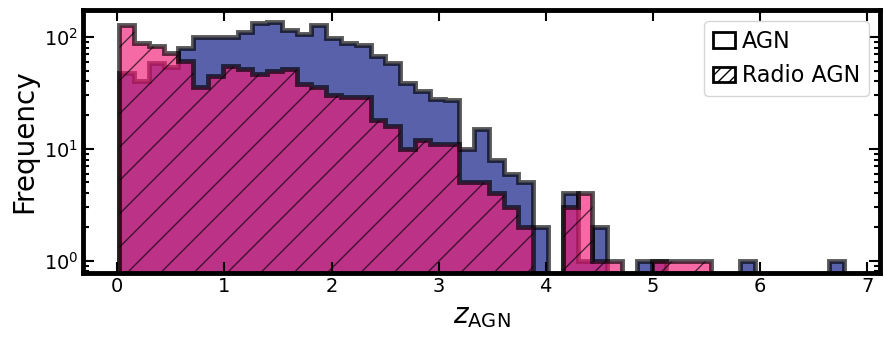

In [24]:
fig             = plt.figure(figsize=(9,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')


filt_AGN        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1)
filt_nrad_AGN   = np.array(full_catalog_df.loc[:, 'radio_detect'] == 0) & np.array(full_catalog_df.loc[:, 'is_AGN'] == 1)
filt_radio_AGN  = np.array(full_catalog_df.loc[:, 'radio_detect'] == 1) & np.array(full_catalog_df.loc[:, 'is_AGN'] == 1)

min_z           = full_catalog_df.loc[:, 'Z'].min()
max_z           = full_catalog_df.loc[:, 'Z'].max()
z_bins          = np.linspace(min_z, max_z, 50)

_, bins, _ = ax1.hist(full_catalog_df.loc[filt_nrad_AGN, 'Z'], bins=z_bins, histtype='stepfilled', ec='k',
                      fc=plt.get_cmap('cet_bmy',3)(0.0), lw=3.5, label='AGN', alpha=0.65, density=False)
ax1.hist(full_catalog_df.loc[filt_radio_AGN, 'Z'], bins=z_bins, histtype='stepfilled', ec='k',
         fc=plt.get_cmap('cet_bmy',3)(0.5), lw=3.5, label='Radio AGN', alpha=0.65, density=False, hatch='/')

AGN_patch       = mpatches.Patch(fc='None', ec='k', label='AGN', lw=2.0)
radio_AGN_patch = mpatches.Patch(fc='None', ec='k', label='Radio AGN', hatch='///', lw=2.0)
ax1.legend(handles=[AGN_patch, radio_AGN_patch], loc=1, fontsize=16,
              handletextpad=0.3, handlelength=1.0)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$z_{\mathrm{AGN}}$', size=20)
# ax1.set_ylabel('Normalised\nFrequency', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
# plt.legend(loc=1, fontsize=14)
# ax1.set_xlim(left=2.8, right=20.2)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_z_radio_non_radio_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


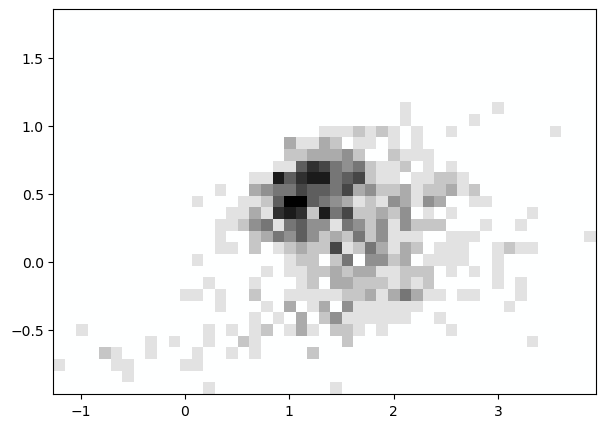

In [25]:
fig_temp             = plt.figure(figsize=(7,5))
ax1_temp             = fig_temp.add_subplot(111, xscale='linear', yscale='linear',  projection='scatter_density')

filt_plot_a = np.array(full_catalog_df.loc[:, 'W1mproPM'] != mag_cols_lim['W1mproPM']) &\
              np.array(full_catalog_df.loc[:, 'W2mproPM'] != mag_cols_lim['W2mproPM']) &\
              np.array(full_catalog_df.loc[:, 'W3mag']    != mag_cols_lim['W3mag'])
filt_agn_a  = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1)

if np.sum(filt_agn_a & filt_plot_a) > 0:
    dens_agn_a  = ax1_temp.scatter_density((full_catalog_df.loc[filt_agn_a & filt_plot_a, 'W2mproPM'] -\
                                        full_catalog_df.loc[filt_agn_a & filt_plot_a, 'W3mag']),\
                                       (full_catalog_df.loc[filt_agn_a & filt_plot_a, 'W1mproPM'] -\
                                        full_catalog_df.loc[filt_agn_a & filt_plot_a, 'W2mproPM']),\
                                       cmap=plt.get_cmap('cet_gray_r'), zorder=0, dpi=10, alpha=1.0)

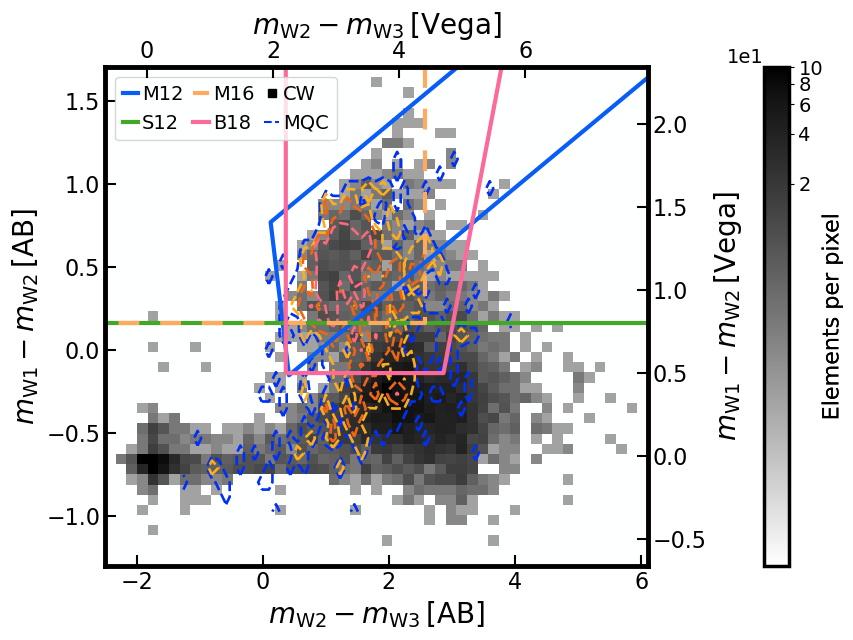

In [26]:
type_of_levels     = 'log'
num_contour_levels = 5

fig                = plt.figure(figsize=(9,6.5))
ax1                = fig.add_subplot(111, xscale='linear', yscale='linear', projection='scatter_density')

if np.sum(filt_agn_a & filt_plot_a) > 0:
    if type_of_levels  == 'linear':
        contour_levels = np.linspace(0.5,\
                                     10**(np.floor(np.log10(np.nanmax(dens_agn_a.get_array())))),\
                                     num_contour_levels)
    if type_of_levels  == 'log':
        contour_levels = np.logspace(np.log10(0.5),\
                                 np.floor(np.log10(np.nanmax(dens_agn_a.get_array()))),\
                                 num_contour_levels)
AB_lims_x          = (-2.5, 6.1)
AB_lims_y          = (-1.3, 1.7)

norm_dens          = ImageNormalize(vmin=0.1, vmax=100, stretch=LogStretch())
if np.sum(filt_agn_a & filt_plot_a) > 0:
    norm_cont          = ImageNormalize(vmin=contour_levels[0], vmax=contour_levels[-1], stretch=LogStretch())

filt_bands         = np.array(full_catalog_df.loc[:, 'W1mproPM']  != mag_cols_lim['W1mproPM']) &\
                     np.array(full_catalog_df.loc[:, 'W2mproPM']  != mag_cols_lim['W2mproPM']) &\
                     np.array(full_catalog_df.loc[:, 'W3mag']     != mag_cols_lim['W3mag'])

filt_plot          = np.isfinite(full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag']) &\
                     np.isfinite(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'])

dens_plot_data_x = (full_catalog_df.loc[filt_bands, 'W2mproPM'] -\
                    full_catalog_df.loc[filt_bands, 'W3mag'])[filt_plot]
dens_plot_data_y = (full_catalog_df.loc[filt_bands, 'W1mproPM'] -\
                    full_catalog_df.loc[filt_bands, 'W2mproPM'])[filt_plot]

dens_1 = ax1.scatter_density(dens_plot_data_x, dens_plot_data_y,
                             cmap=plt.get_cmap('cet_gray_r'),
                             zorder=0, dpi=10, norm=norm_dens, alpha=1.0)

if np.sum(filt_agn_a & filt_plot_a) > 0:
    xx_agn = np.linspace(dens_agn_a.get_extent()[0], dens_agn_a.get_extent()[1], np.shape(dens_agn_a.get_array())[1])
    yy_agn = np.linspace(dens_agn_a.get_extent()[2], dens_agn_a.get_extent()[3], np.shape(dens_agn_a.get_array())[0])

    ax1.contour(xx_agn, yy_agn, np.flipud(dens_agn_a.get_array()), levels=contour_levels,\
                linewidths=1.9, cmap=plt.get_cmap('cet_CET_R1'), linestyles='--', zorder=1, norm=norm_cont)

x_Vega   = np.array(AB_lims_x) - 3.339 + 5.174  # Vega
y_Vega   = np.array(AB_lims_y) - 2.699 + 3.339  # Vega
# Mateos+2012
y_M12_a = 0.315 * (x_Vega) + 0.791
y_M12_b = 0.315 * (x_Vega) - 0.222
y_M12_c = -3.172 * (x_Vega) + 7.624
# Stern+2012
# Toba+2014
# Mingo+2016
# # Assef+2018 (75% completeness)
# y_A18_75 = 0.530 * np.exp(0.183 * (full_catalog_df.loc[filt_plot, 'W2mproPM'] - 3.339 - 13.76)**2)
# # Assef+2018 (90% completeness)
# y_A18_90 = 0.662 * np.exp(0.232 * (full_catalog_df.loc[filt_plot, 'W2mproPM'] - 3.339 - 13.97)**2)
# Blecha+2018
points_M12 = np.array([[x_Vega[-1], 1.9596, 2.2501, x_Vega[-1]], [y_M12_a[-1], 1.4083, 0.4867, y_M12_b[-1]]])
points_M16 = np.array([[4.4, 4.4, x_Vega[0], x_Vega[0]], [y_Vega[-1], 0.8, 0.8, y_Vega[-1]]])
points_B18 = np.array([[2.2, 2.2, 4.7, (y_Vega[-1] + 8.9) * 0.5], [y_Vega[-1], 0.5, 0.5, y_Vega[-1]]])

ax1.plot(points_M12[0] + 3.339 - 5.174, points_M12[1] + 2.699 - 3.339, label='M12',\
                c=plt.get_cmap('cet_CET_R3')(0.0), zorder=2, lw=3)
ax1.axhline(y=0.8 + 2.699 - 3.339, label='S12', c=plt.get_cmap('cet_CET_R3')(0.2),\
                   zorder=2, lw=3)
ax1.plot(points_M16[0] + 3.339 - 5.174, points_M16[1] + 2.699 - 3.339, label='M16',\
                c=plt.get_cmap('cet_CET_R3')(0.6), zorder=2, lw=3, ls=(0, (5, 5)))
ax1.plot(points_B18[0] + 3.339 - 5.174, points_B18[1] + 2.699 - 3.339, label='B18',\
                c=plt.get_cmap('cet_CET_R3')(0.75), zorder=2, lw=3)

ax1.plot([-3], [-3], marker='s', ls='None', c=plt.get_cmap('cet_gray_r')(1.1), label='CW', zorder=0)
if np.sum(filt_agn_a & filt_plot_a) > 0:
    ax1.plot([-3], [-3], marker=None, ls='--', c=plt.get_cmap('cet_CET_R1')(0.0), label='MQC', zorder=0)
    
clb = plt.colorbar(dens_1, extend='neither', pad=0.15)
clb.formatter.set_powerlimits((0, 0))
clb.ax.tick_params(labelsize=14)
clb.ax.yaxis.get_offset_text().set_fontsize(14)
# clb.ax.yaxis.set_offset_position('right')
clb.ax.yaxis.get_offset_text().set_position((0,0))
clb.outline.set_linewidth(2.5)
clb.update_ticks()
clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2, labelpad=-2)
ax1.set_xlim(left=AB_lims_x[0], right=AB_lims_x[1])
ax1.set_ylim(bottom=AB_lims_y[0], top=AB_lims_y[1])
ax1.legend(loc=2, fontsize=14, ncol=3, columnspacing=.5, handletextpad=0.2, handlelength=0.8)

# vega_shift     = {'W1mproPM': 2.699, 'W2mproPM': 3.339, 'W1mag': 2.699, 'W2mag': 3.339, 'W3mag': 5.174,\
#                   'W4mag': 6.620, 'Jmag': 0.910, 'Hmag': 1.390, 'Kmag': 1.850, 'gmag': 0.4810,\
#                     'rmag': 0.6170, 'imag': 0.7520, 'zmag': 0.8660, 'ymag': 0.9620}

ax2 = ax1.twinx()
ax2.set_ylim(tuple(np.array(ax1.get_ylim()) - 2.699 + 3.339))
ax2.tick_params(which='both', top=False, right=True, direction='in')
ax2.tick_params(which='both', bottom=False, left=False, direction='in')
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(which='major', length=8, width=1.5)
ax2.tick_params(which='minor', length=4, width=1.5)
ax2.set_ylabel('$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[Vega]}$', size=20)

ax3 = ax1.twiny()
ax3.set_xlim(tuple(np.array(ax1.get_xlim()) - 3.339 + 5.174))
ax3.tick_params(which='both', top=True, right=False, direction='in')
ax3.tick_params(which='both', bottom=False, left=False, direction='in')
ax3.tick_params(axis='both', which='major', labelsize=16)
ax3.tick_params(which='major', length=8, width=1.5)
ax3.tick_params(which='minor', length=4, width=1.5)
ax3.set_xlabel('$m_{\mathrm{W2}} - m_{\mathrm{W3}}\, \mathrm{[Vega]}$', size=20)

ax1.tick_params(which='both', top=False, right=False, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$m_{\mathrm{W2}} - m_{\mathrm{W3}}\, \mathrm{[AB]}$', size=20)
ax1.set_ylabel('$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[AB]}$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/W1_W2_W3_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()